In [1]:
import rlssm
import pandas as pd
import os

#### Import the grouped data

In [2]:
par_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(par_path, 'data/data_experiment.csv')

data = pd.read_csv(data_path, index_col=0)

data = data[data.participant <3 ].reset_index(drop=True)

data['block_label'] += 1

data.head()

,participant,block_label,trial_block,f_cor,f_inc,cor_option,inc_option,times_seen,rt,accuracy
0,1,0.0,1.0,43.0,39.0,2,1,1.0,1.244082,0.0
1,1,0.0,2.0,60.0,50.0,4,3,1.0,1.101821,1.0
2,1,0.0,3.0,44.0,36.0,4,2,2.0,1.029923,0.0
3,1,0.0,4.0,55.0,55.0,4,3,2.5,1.368007,0.0
4,1,0.0,5.0,52.0,49.0,4,3,3.5,1.039329,1.0


#### Initialise the model

In [3]:
model = rlssm.RLDDModel(hierarchical_levels=2, separate_learning_rates=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e20e5c0b8026b71eda14ab4f2bcdb959 NOW.


In [4]:
model.family, model.model_label, model.hierarchical_levels

('RLDDM', 'hierRLDDM_2lr', 2)

### Fit

In [8]:
# sampling parameters
n_iter = 1000
n_chains = 2
n_thin = 1

# learning parameters
K = 4 # n options
initial_value_learning = 27.5 # intitial value (Q0)

# bayesian model
alpha_priors = None
drift_scaling_priors = None
threshold_priors = None
ndt_priors = None

In [6]:
# User-Supplied Initial Values:
n_participants = len(data.participant.unique())

def starting_values(chain_id, n_participants=n_participants):
    import numpy as np
    from scipy import stats
    
    out = {
        'mu_alpha_pos': stats.norm.ppf(.1),
        'mu_alpha_neg': stats.norm.ppf(.1),
        #'mu_alpha': stats.norm.ppf(.1),
        'mu_drift_scaling': np.log(.5),
        #'mu_drift_asymptote': np.log(5),
        'mu_threshold': np.log(2),
        'mu_ndt': np.log(.1),
    
        'sd_alpha_pos':.1,
        'sd_alpha_neg':.1,
        #'sd_alpha':.1,
        'sd_drift_scaling':.1,
        #'sd_drift_asymptote':.1,
        'sd_threshold':.1,
        'sd_ndt':.1,
        
        'z_alpha_pos':list(np.random.normal(0, 1, n_participants)),
        'z_alpha_neg':list(np.random.normal(0, 1, n_participants)),
        #'z_alpha':list(np.random.normal(0, 1, n_participants)),
        'z_drift_scaling':list(np.random.normal(0, 1, n_participants)),
        #'z_drift_asymptote':list(np.random.normal(0, 1, n_participants)),
        'z_threshold':list(np.random.normal(0, 1, n_participants)),
        'z_ndt':list(np.random.normal(0, 1, n_participants))
    }
    
    return out

In [9]:
model_fit = model.fit(
    data,
    K,
    initial_value_learning,
    alpha_priors=alpha_priors,
    drift_scaling_priors=drift_scaling_priors,
    threshold_priors=threshold_priors,
    ndt_priors=ndt_priors,
    thin = n_thin,
    iter = n_iter,
    chains = n_chains,
    init=starting_values,
    verbose = False)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [10]:
model_fit

#### get Rhat

In [11]:
Rhat = model_fit.check_convergence()

Rhat.describe()

,Rhat
count,145.000000
mean,1.006226
std,0.012451
min,0.998058
25%,0.999112
50%,1.000696
75%,1.003965
max,1.040431


In [12]:
Rhat.head()

,Rhat,variable
0,0.998673,mu_alpha_pos
1,0.999369,mu_alpha_neg
2,1.009002,mu_drift_scaling
3,0.999211,mu_threshold
4,1.038013,mu_ndt


#### calculate wAIC

In [13]:
wAIC = model_fit.calculate_wAIC()
wAIC

{'lppd': -5073.127041757691,
 'p_waic': 121.89142698609223,
 'waic': 10390.036937487566,
 'waic_se': 164.40973825216705}

#### Check divergences

In [14]:
model_fit.check_divergencies()

0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior
0.0 of 1000 iterations ended with a divergence (0.0%)


#### Get posteriors

In [15]:
samples = model_fit.get_posteriors(pars=model_fit.parameters_names, permuted=True, diagnostics=False)

In [16]:
samples.head()

,chain,draw,warmup,permutation,chain_permutation,permutation_order,chain_permutation_order,mu_alpha_neg,mu_alpha_pos,mu_drift_scaling,...,z_threshold[26],z_threshold[27],z_threshold[2],z_threshold[3],z_threshold[4],z_threshold[5],z_threshold[6],z_threshold[7],z_threshold[8],z_threshold[9]
260,0,260,0,174,174,0,0,-0.841773,-1.250379,-1.952332,...,-1.089534,0.029479,-1.142271,-1.506198,1.117372,0.011909,-0.669921,0.879887,0.889479,1.297485
266,0,266,0,209,209,1,1,-0.712979,-1.443392,-1.985834,...,-1.231953,0.434709,-0.349994,-1.294903,0.643674,-0.059432,-0.392953,0.026343,0.382552,0.820563
261,0,261,0,242,242,2,2,-0.895177,-1.454514,-1.997468,...,-1.519741,0.075557,-0.228009,-0.962915,0.707029,-0.423562,-0.778380,0.127262,0.671746,0.906692
322,0,322,0,130,130,3,3,-0.893376,-1.427936,-2.023013,...,-1.011000,0.515643,-0.680109,-0.962483,1.368092,-0.053512,-0.425020,0.495406,1.056393,1.173543
449,0,449,0,129,129,4,4,-1.031184,-1.338747,-1.937569,...,-1.296809,0.326273,-0.372115,-1.279348,1.113813,-0.244447,-1.044685,0.398925,0.648810,1.183846


In [17]:
import seaborn as sns
sns.set(context = "talk", 
        style = "white", 
        palette = "husl",
        rc={'figure.figsize':(15, 8)})

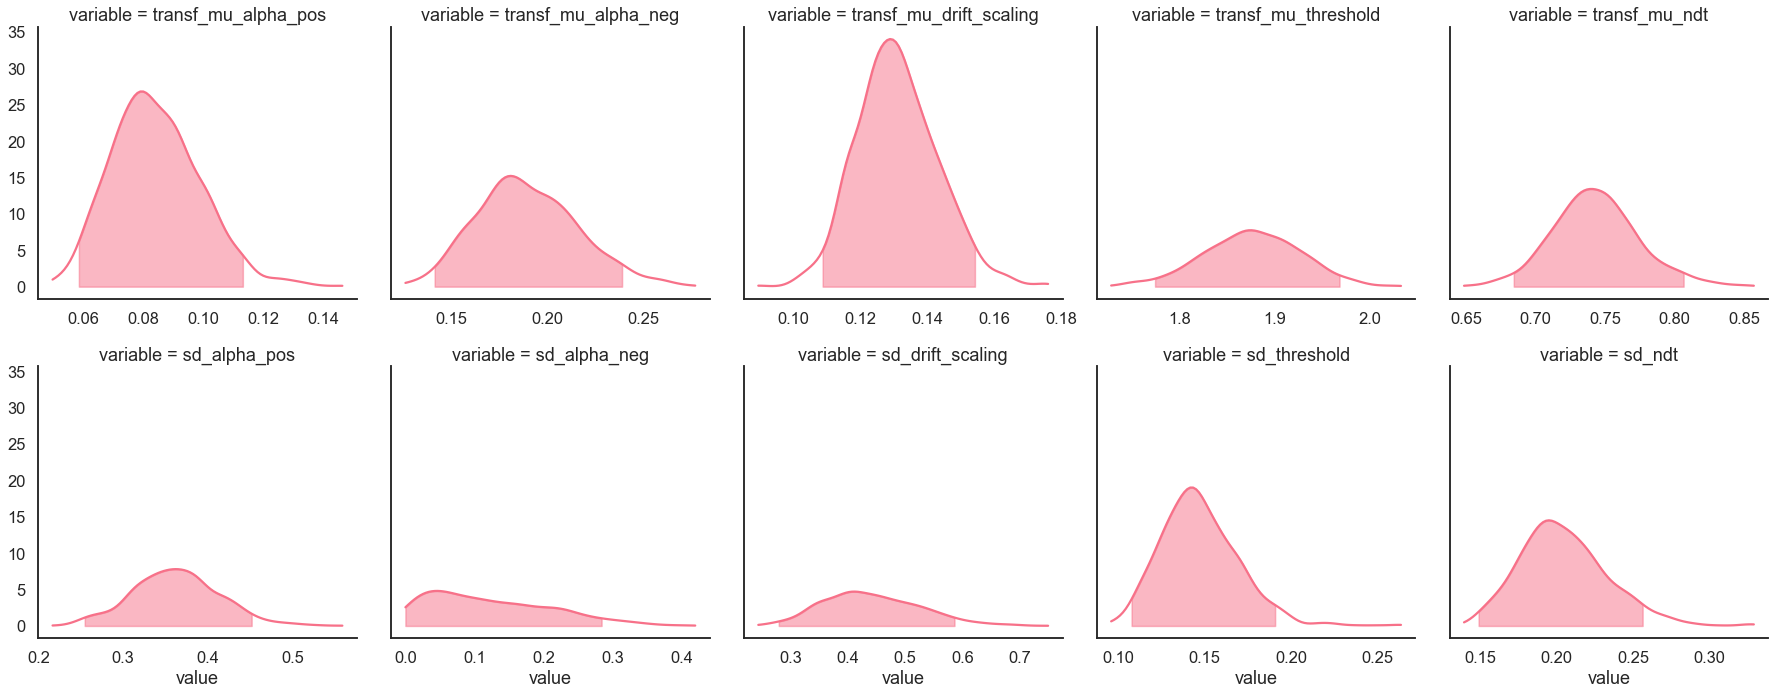

In [18]:
model_fit.plot_posteriors(height=5, show_intervals='HDI')

### Posterior predictives

In [19]:
import numpy as np

In [20]:
data['choice_pair'] = 'AB'
data.loc[(data.cor_option == 3) & (data.inc_option == 1), 'choice_pair'] = 'AC'
data.loc[(data.cor_option == 4) & (data.inc_option == 2), 'choice_pair'] = 'BD'
data.loc[(data.cor_option == 4) & (data.inc_option == 3), 'choice_pair'] = 'CD'

data['block_bins'] = pd.cut(data.trial_block, 8, labels=np.arange(1, 9))

In [21]:
data.head()

,participant,block_label,trial_block,f_cor,f_inc,cor_option,inc_option,times_seen,rt,accuracy,accuracy_neg,choice_pair,block_bins
0,1,0.0,1.0,43.0,39.0,2,1,1.0,1.244082,0.0,-1,AB,1
1,1,0.0,2.0,60.0,50.0,4,3,1.0,1.101821,1.0,1,CD,1
2,1,0.0,3.0,44.0,36.0,4,2,2.0,1.029923,0.0,-1,BD,1
3,1,0.0,4.0,55.0,55.0,4,3,2.5,1.368007,0.0,-1,CD,1
4,1,0.0,5.0,52.0,49.0,4,3,3.5,1.039329,1.0,1,CD,1


#### Ungrouped posterior predictives:

In [22]:
pp = model_fit.get_posterior_predictives(n_posterior_predictives=100)

pp.head()

variable        rt                                                    \
trial         1         2         3         4         5         6      
sample                                                                 
1         1.306545  1.306545  2.023545  1.084545  1.056545  2.050545   
2         1.787038  1.387038  2.026038  1.315038  2.277038  2.227038   
3         0.966609  1.465609  2.079609  1.595609  1.173609  0.956609   
4         1.171341  1.052341  2.919341  1.391341  1.152341  1.208341   
5         1.266836  0.971836  3.115836  1.192836  1.430836  1.231836   

variable                                          ... accuracy                 \
trial         7         8         9         10    ...     6455 6456 6457 6458   
sample                                            ...                           
1         1.537545  3.086545  1.064545  1.236545  ...      1.0  1.0  1.0  1.0   
2         2.204038  1.963038  1.637038  1.058038  ...      0.0  1.0  1.0  0.0   
3         1.539609  1.308609  1.432609  1.294609  ...      1.0  0.0  1.0  1.0   
4         1.345341  1.622341  1.054341  1.969341  ...      1.0  1.0  1.0  1.0   
5         1.236836  3.883836  1.750836  1.325836  ...      1.0  1.0  1.0  1.0   

variable                                
trial    6459 6460 6461 6462 6463 6464  
sample                                  
1         1.0  0.0  1.0  1.0  1.0  1.0  
2         1.0  1.0  1.0  1.0  1.0  1.0  
3         1.0  1.0  0.0  1.0  1.0  1.0  
4         1.0  1.0  1.0  1.0  1.0  1.0  
5         1.0  1.0  1.0  1.0  1.0  1.0  

[5 rows x 12928 columns]

#### Grouped posterior predictives:

In [23]:
pp_grouped = model_fit.get_grouped_posterior_predictives_summary(grouping_vars=['choice_pair', 'block_bins'], 
                                                                 n_posterior_predictives=100)

In [24]:
pp_grouped.head()

,choice_pair,block_bins,mean_acc,mean_rt,skew_rt,quant_10_rt_up,quant_30_rt_up,quant_50_rt_up,quant_70_rt_up,quant_90_rt_up,quant_10_rt_low,quant_30_rt_low,quant_50_rt_low,quant_70_rt_low,quant_90_rt_low
0,AB,1,0.530,1.708106,2.087279,0.959960,1.241273,1.510122,1.939646,2.630133,0.973577,1.231572,1.469926,1.831486,2.528773
1,AB,1,0.560,1.623900,1.599596,0.941890,1.145742,1.419347,1.862233,2.874630,0.971501,1.158428,1.320803,1.775288,2.392384
2,AB,1,0.600,1.631755,1.857972,0.895078,1.181709,1.443460,1.898144,3.109845,0.912022,1.175177,1.341136,1.615867,2.342661
3,AB,1,0.535,1.609354,1.198183,1.013557,1.209597,1.442612,1.711396,2.415870,0.911211,1.106299,1.425022,1.859146,2.691124
4,AB,1,0.555,1.788012,1.738490,0.968836,1.167993,1.413387,1.864472,3.049472,0.943137,1.253560,1.544627,2.105236,2.841383


#### Plot grouped posterior predictives:

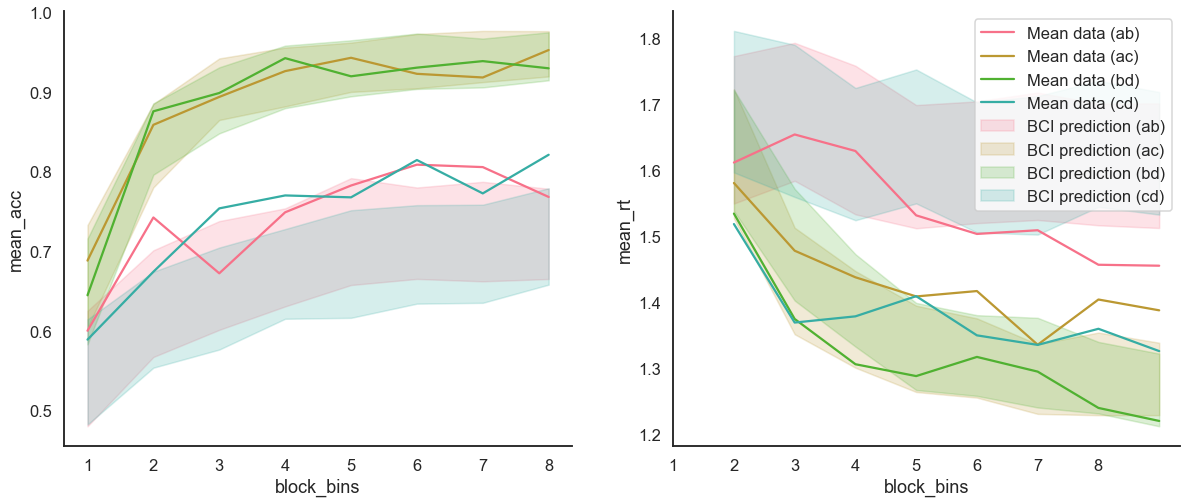

In [25]:
model_fit.plot_mean_grouped_posterior_predictives(
    grouping_vars=['block_bins', 'choice_pair'],
    n_posterior_predictives=300,
    figsize=(20,8),
    hue_labels=['ab', 'ac', 'bd', 'cd'],
    hue_order=['AB', 'AC', 'BD', 'CD'],
    palette= sns.color_palette('husl'))

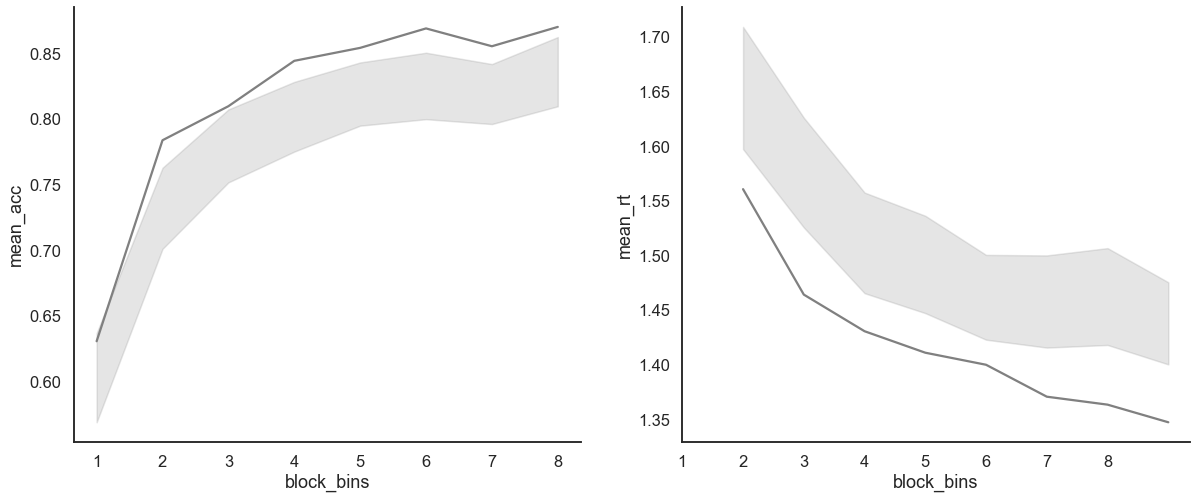

In [26]:
model_fit.plot_mean_grouped_posterior_predictives(
    grouping_vars=['block_bins'],
    n_posterior_predictives=300,
    figsize=(20,8))

### Get starting values for further sampling

In [27]:
sv = model_fit.get_starting_values()
sv

,chain,draw,warmup,mu_alpha_neg,mu_alpha_pos,mu_drift_scaling,mu_ndt,mu_threshold,sd_alpha_neg,sd_alpha_pos,...,z_threshold[26],z_threshold[27],z_threshold[2],z_threshold[3],z_threshold[4],z_threshold[5],z_threshold[6],z_threshold[7],z_threshold[8],z_threshold[9]
499,0,499,0,-0.980114,-1.358785,-2.051873,-0.295776,0.615717,0.128340,0.360502,...,-1.705857,0.727738,-1.046693,-1.568118,0.825893,-0.015499,-0.935959,0.073950,1.251308,1.501741
999,1,499,0,-0.878408,-1.486506,-1.924043,-0.294161,0.613890,0.029108,0.263135,...,-0.967082,0.076098,-0.463451,-1.061295,0.811090,-0.070403,-0.328280,0.063761,0.995615,0.559928
